In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
params = {'axes.labelsize': 14,
          'axes.labelweight': 'bold',
          'axes.titlesize': 16,
          'figure.titleweight': 'bold'}
colors = {'Delinquent':'#00BEC5', 'Current':'#00BEC5', 'Paird':'#00BEC5'}
plt.rcParams.update(params)

## Exploratory Analysis

In this dataset, there are 1000 unique loans between 5/31/15 and 7/25/15 consisting of 3 statuses `Paid`, `Delinquent`, and `Current`.<br/>
The median loan amount is \$2357. All loan amounts are < \$5000 with the exception of one outlier which has loan amount \$3.98M. I removed this outlier for the remainder of the analysis.<br/>

From the histogram of loan amounts, we can see that the number of loans are roughly equally distributed across the various loan amounts, with the largest category being loans under \$1000.

In [2]:
all_loans = pd.read_csv('Fundbox_Interviewing_Analytics_Data_Set.csv')
all_loans.Date = pd.to_datetime(all_loans.Date, format='%m/%d/%y')
all_loans.sort_values(by=['Date'])
all_loans.head()

,Loan ID,Amount,Date,Status
0,313,3268,2015-05-31,Paid
1,642,2228,2015-05-31,Paid
2,744,2151,2015-05-31,Paid
3,346,4185,2015-06-01,Paid
4,130,100,2015-06-01,Paid


In [3]:
all_loans.describe()

,Loan ID,Amount
count,1000.000000,1.000000e+03
mean,500.500000,6.353021e+03
std,288.819436,1.260457e+05
min,1.000000,1.000000e+02
25%,250.750000,1.072750e+03
50%,500.500000,2.357000e+03
75%,750.250000,3.657000e+03
max,1000.000000,3.988000e+06


In [4]:
# Get number of unique loans
all_loans['Loan ID'].nunique()

1000

In [5]:
# Get counts for each status
all_loans['Status'].value_counts()

Paid          717
Current       206
Delinquent     77
Name: Status, dtype: int64

In [6]:
# Get outlier
all_loans[all_loans.Amount > 5000]

,Loan ID,Amount,Date,Status
113,526,3988000,2015-06-04,Paid


In [7]:
# From now on, only consider data with outlier removed
loans = all_loans[all_loans.Amount <= 5000]

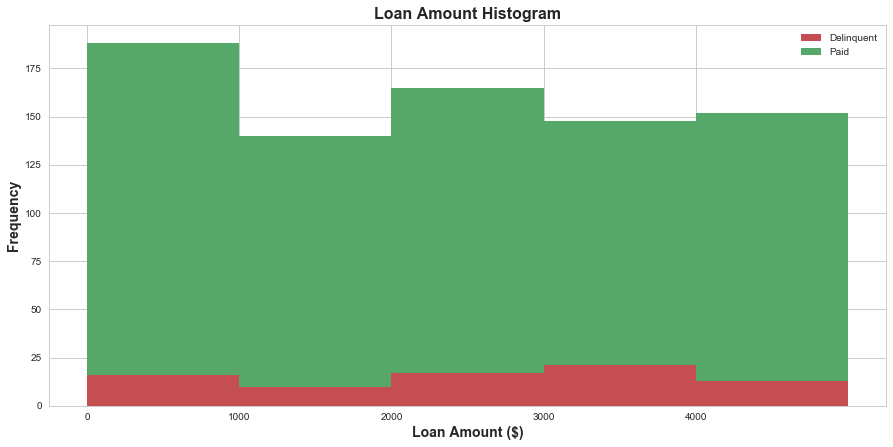

In [8]:
def plot_histogram(input_loans):
    """
    Stacked histogram of loan amounts for paid and delinquent loans
    """
    loans_paid = input_loans.groupby('Status').get_group('Paid')
    loans_delinquent = input_loans.groupby('Status').get_group('Delinquent')

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Loan Amount ($)')
    ax.xaxis.set_ticks(np.arange(0, 5000, 1000))
    ax.set_title('Loan Amount Histogram', fontweight='bold')

    pd.DataFrame({
        'Paid': loans_paid.Amount,
        'Delinquent': loans_delinquent.Amount
    }).plot.hist(stacked=True, bins=5, ax=ax, 
                 color=['#c44e52', '#55a868'], range=(0, 5000))

plot_histogram(loans)

## Delinquency Analysis

Total number of loans roughly constant at around 130 per week during the 8 week span.<br/>

I split the loans into 3 sizes:
    - $0-$1500 (Small) 
    - $1500-$3000 (Medium) 
    - $3000+ (Large) 
Small loans have the smallest overall delinquency rates (5.78%) whilst large loans have the largest delinquency rate (9.16%).<br/>

For the sake of simplicity, I assume that this data snapshot was taken one week after the last loan in the dataset.  Then we can see that the probability of delinquency increases with the age of the loan. As time passes, there are less 'Current' loans and more loans that either 'Paid' or 'Delinquent'. This makes sense since as the number of installments increases, the probability that the business will make all the payments decreases.

In [9]:
def categorize_amount(amount):
    if (amount >= 0) and (amount < 1500):
        return '\$0-\$1500'
    elif (amount >= 1500) and (amount < 3000):
        return '\$1500-\$3000'
    elif (amount >= 3000):
        return '\$3000+'
    
# Add columns 'Date_Week' and 'Amount_Category'
loans['Amount_Category'] = loans['Amount'].map(categorize_amount)
loans['Date_Week'] = loans['Date'].dt.to_period('W')

# Sample of loans data with new columns
loans.head()

,Loan ID,Amount,Date,Status,Amount_Category,Date_Week
0,313,3268,2015-05-31,Paid,\$3000+,2015-05-25/2015-05-31
1,642,2228,2015-05-31,Paid,\$1500-\$3000,2015-05-25/2015-05-31
2,744,2151,2015-05-31,Paid,\$1500-\$3000,2015-05-25/2015-05-31
3,346,4185,2015-06-01,Paid,\$3000+,2015-06-01/2015-06-07
4,130,100,2015-06-01,Paid,\$0-\$1500,2015-06-01/2015-06-07


Status,Amount_Category,Current,Delinquent,Paid,Total_Loan_Count,Delinquency_Rate
0,\$0-\$1500,75,19,235,329,5.775076
1,\$1500-\$3000,60,24,215,299,8.026756
2,\$3000+,71,34,266,371,9.164420


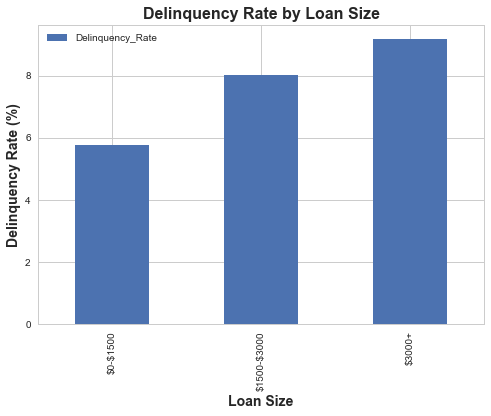

In [13]:
def delinquency_by_amount(input_loans):
    loans_pivot = input_loans.groupby(['Amount_Category', 'Status']).agg('count').reset_index().pivot(
                                index='Amount_Category', columns='Status', values='Loan ID').reset_index()

    loans_pivot['Total_Loan_Count'] = loans_pivot['Delinquent'] + loans_pivot['Paid'] + loans_pivot['Current'] 
    loans_pivot['Delinquency_Rate'] = loans_pivot['Delinquent'] * 100 / loans_pivot['Total_Loan_Count']
    p1 = loans_pivot.plot.bar('Amount_Category', 'Delinquency_Rate')
    p1.set_xlabel('Loan Size')
    p1.set_ylabel('Delinquency Rate (%)')
    p1.set_title('Delinquency Rate by Loan Size', fontweight='bold')
    return loans_pivot

    
# Check if there is any difference in delinquency rate as loan amount increases
delinquency_by_amount(loans)

Status,Date_Week,Current,Delinquent,Paid,Week_Loan_Count,Delinquency_Percentage
Age (Weeks),,,,,,
1,2015-07-20/2015-07-26,62.0,1.0,55.0,118.0,0.847458
2,2015-07-13/2015-07-19,27.0,0.0,73.0,100.0,0.000000
3,2015-07-06/2015-07-12,36.0,5.0,95.0,136.0,3.676471
4,2015-06-29/2015-07-05,25.0,9.0,97.0,131.0,6.870229
5,2015-06-22/2015-06-28,24.0,11.0,95.0,130.0,8.461538
6,2015-06-15/2015-06-21,19.0,13.0,101.0,133.0,9.774436
7,2015-06-08/2015-06-14,5.0,17.0,95.0,117.0,14.529915
8,2015-06-01/2015-06-07,8.0,21.0,102.0,131.0,16.030534


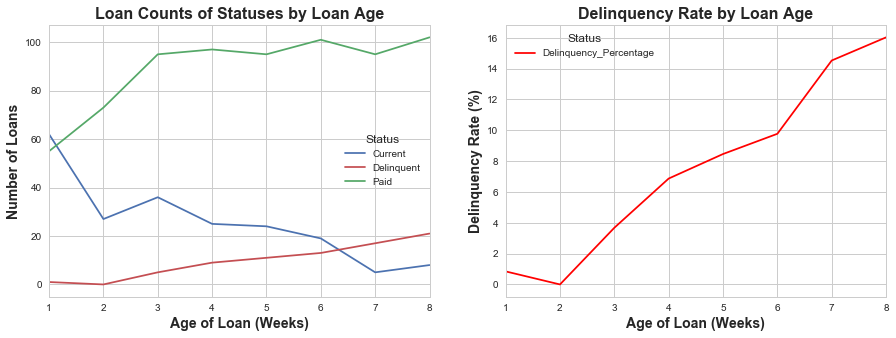

In [11]:
def weekly_loan_delinquency(input_loans, amount_category=None):
    """
    Plot the number of loans per week, and the total delinquency percentage by week.
    Option to filter input loans by loan amount category.
    """
    filtered_input_loans = input_loans
    if amount_category:
        filtered_input_loans = input_loans[input_loans.Amount_Category == amount_category]
        
    loans_weekly = filtered_input_loans.groupby(['Date_Week', 'Status']).agg(['count'])['Loan ID'].reset_index()
    loans_weekly = loans_weekly.pivot(
        index='Date_Week', columns='Status', values='count').reset_index().fillna(0)
    loans_weekly['Week_Loan_Count'] = loans_weekly['Delinquent'] + loans_weekly['Paid'] + loans_weekly['Current'] 
    loans_weekly['Delinquency_Percentage'] = loans_weekly['Delinquent'] * 100 / loans_weekly['Week_Loan_Count']
    loans_weekly = loans_weekly[1:]
    loans_weekly['Age (Weeks)'] = 9 - loans_weekly.index
    loans_weekly = loans_weekly.sort_values(by=['Age (Weeks)'])
    loans_weekly = loans_weekly.set_index('Age (Weeks)')
    return loans_weekly

def plot_weekly_loan_delinquency():
    
    weekly_loans = weekly_loan_delinquency(loans)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
   
    p1 = weekly_loans.loc[:, ['Current', 'Delinquent', 'Paid']].plot(
        ax=ax[0], color=['#4c72b0', '#c44e52', '#55a868'])
    p1.set_xlabel('Age of Loan (Weeks)')
    p1.set_ylabel('Number of Loans')
    p1.set_title('Loan Counts of Statuses by Loan Age', fontweight='bold')
    
    p2 = weekly_loans.loc[:, ['Delinquency_Percentage']].plot(
        ax=ax[1], color='red')
    p2.set_xlabel('Age of Loan (Weeks)')
    p2.set_ylabel('Delinquency Rate (%)')
    p2.set_title('Delinquency Rate by Loan Age', fontweight='bold')
    return weekly_loans

plot_weekly_loan_delinquency()

## Pricing

Let `f` be the additional fee for each installment of the loan. Fundbox should determine the fee according to:

    1. Fundbox's desired return rate on the loan (`r`)
    2. Deliquency probability per installment (`p`). This will inform the expected total payment.

The delinquency probability `p` depends on the loan size (see above).

We can model the sum of the expected loan installments as a **geometric series**:

Let `n = number of installments` and `w = weekly installment payment`.<br/>
```
Expected total from payments of loan = ((w+f)\*(1-p)) + ((w+f)\*(1-p)^2) + ... ((w+f)\*(1-p)^n)<br/>
= (w+f)((1-(1-p)^(n+1))/(n+1))-1)

We can solve for f:
f = (Expected total from payments /((1-(1-p)^(n+1))/(n+1))) - w
```


### Example Case

Let's assume that Fundbox wants to make 10% return on a \$1000 loan (\$100 with `r=0.1`). We therefore need to choose weekly fee `f` so that the total expected return on the loan = \$1100. This loan falls under the **'small'** size with estimated delinquency probability `p=0.0578` for each installment. Let's assume the loan is paid over 4 weeks in installments of \$275 + fee `f`.

| Week          | Probability of Payment | Expected Payment for Week |
| ------------- |------------------------| --------------------------|
| Week 1        | 1-p=(1-0.0578)=0.9422  | 0.9422\*(\$275+f) |
| Week 2        | (1-p)^2 = 0.8877       | 0.8877\*(\$275+f) |
| Week 3        | (1-p)^3 = 0.8364       | 0.8364\*(\$275+f) |
| Week 4        | (1-p)^4 = 0.7881       | 0.7881\*(\$275+f) |

The total expected payment for this loan with no fee (`f=0`) is \$950. In general, this can be calculated by summing the expected payment per week as a geometric series.<br/>

To make up this \$1100-\$950=\$150 difference, Fundbox needs to add a weekly fee of `f=\$43` for a total weekly installment of \$318.



## Other Considerations

Given the limited number of features provided, we can only model risk based on loan amount. Ideally we would have more information on the business, such as weekly revenue, to predict whether it will default on a loan. 

Other factors that might affect Fundbox's desired return rate include available supply of cash and whether Fundbox wants to incentivize more borrowing. I.e. Fundbox should lower its desired return rate if it wants more businesses to borrow.